C:\Users\Eugene\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


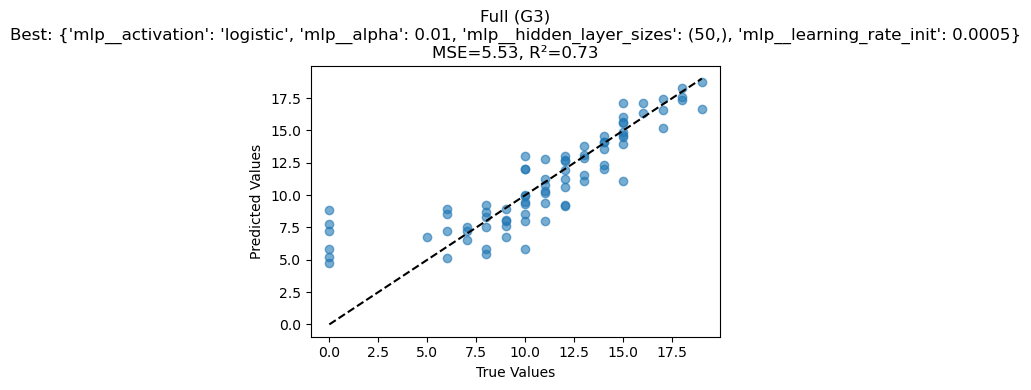

C:\Users\Eugene\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


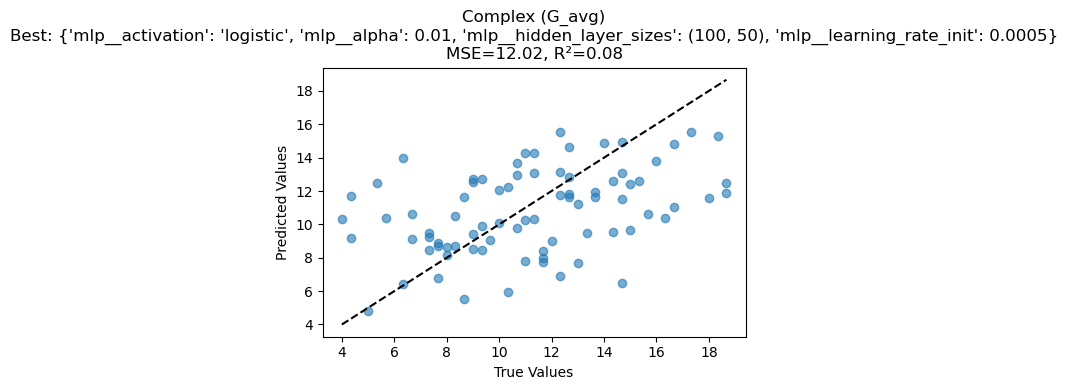

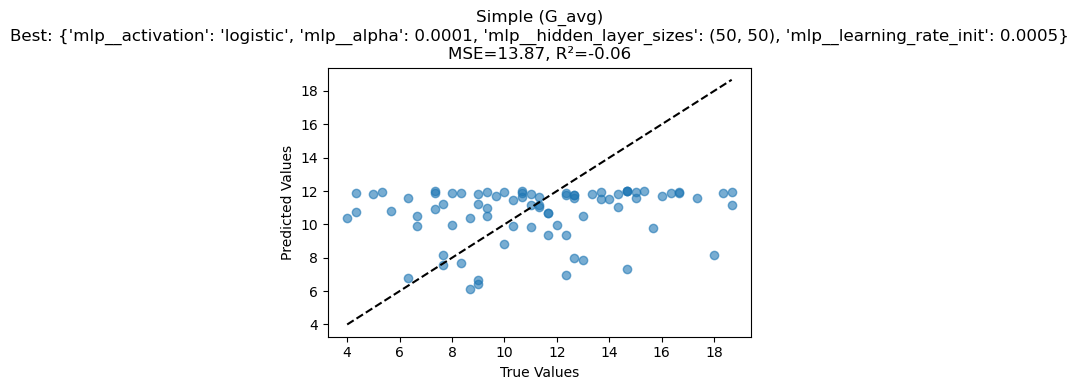

,Dataset,Best Params,MSE,R2
0,Full (G3),"{'mlp__activation': 'logistic', 'mlp__alpha': ...",5.530724,0.732280
1,Complex (G_avg),"{'mlp__activation': 'logistic', 'mlp__alpha': ...",12.018470,0.078003
2,Simple (G_avg),"{'mlp__activation': 'logistic', 'mlp__alpha': ...",13.868215,-0.063900


In [68]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def load_math_dataset():
    full_dataset = pd.read_csv("Math-Students.csv", sep=",")

    # Create dataset with all data for testing
    fData_X = full_dataset.drop("G3", axis=1)
    fData_y = full_dataset["G3"]
    fData_X = pd.get_dummies(fData_X, drop_first=False)  # one-hot encode categorical features

    # Change output label to average of grades
    grades = ['G1', 'G2', 'G3']
    full_dataset['G_avg'] = full_dataset[grades].mean(axis=1)
    full_dataset = full_dataset.drop(columns=grades)

    # Split X and y for complex dataset (all non-correlated features)
    correlation_drop = ['Dalc', 'Walc', 'Fedu']
    complex_dataset = full_dataset.drop(columns=correlation_drop)
    cData_X = complex_dataset.drop("G_avg", axis=1)
    cData_y = complex_dataset["G_avg"]
    cData_X = pd.get_dummies(cData_X, drop_first=False)  # one-hot encode categorical features

    # Split X and y for simple dataset (only features with highest G_avg correlation)
    best_features = ['failures', 'Medu', 'goout', 'age', 'studytime', 'traveltime']
    simple_dataset = complex_dataset[best_features + ['G_avg']]
    sData_X = simple_dataset.drop("G_avg", axis=1)
    sData_y = simple_dataset["G_avg"]
    sData_X = pd.get_dummies(sData_X, drop_first=False)  # one-hot encode categorical features
    
    return (fData_X, fData_y), (cData_X, cData_y), (sData_X, sData_y)


(full_X, full_y), (comp_X, comp_y), (simp_X, simp_y) = load_math_dataset()
datasets = {
    "Full (G3)":      (full_X, full_y),
    "Complex (G_avg)":(comp_X, comp_y),
    "Simple (G_avg)": (simp_X, simp_y)
}

# Hidden layers
architectures = [(50,), (50,50), (100,50), (100,100,50)]

# Gridsearch for hyperparameters
param_grid = {
    'mlp__hidden_layer_sizes': architectures,
    'mlp__alpha': [1e-4, 1e-3, 1e-2],
    'mlp__learning_rate_init': [5e-4, 1e-3, 1e-2],
    'mlp__activation': ['relu', 'tanh', 'logistic']
}


results = []
for name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(max_iter=2000, random_state=42))
    ])
    
    grid = GridSearchCV(pipe, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_pipe = grid.best_estimator_
    y_pred = best_pipe.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    
    results.append({
        "Dataset": name,
        "Best Params": grid.best_params_,
        "MSE": mse,
        "R2": r2
    })
    
    plt.figure(figsize=(5,4))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], 'k--')
    plt.title(f"{name}\nBest: {grid.best_params_}\nMSE={mse:.2f}, R²={r2:.2f}")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.tight_layout()
    plt.show()

pd.DataFrame(results)
